In [1]:
import numpy as np
import pandas as pd
import h5py


import pybel
from tfbio.data import Featurizer

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# path to the extracted PDBbind dataset
path = '../PDBbind'
print(path)

../PDBbind


# Parse and clean affinity data

In [3]:
%%bash -s $path --out missing

path=$1

# Save binding affinities to csv file
echo $path > 1

echo 'pdbid,-logKd/Ki' > affinity_data.csv
cat $path/plain-text-index/index/INDEX_general_PL_data.2019 | while read l1 l2 l3 l4 l5; do
    if [[ ! $l1 =~ "#" ]]; then
        echo $l1,$l4
    fi
done >> affinity_data.csv


# Find affinities without structural data (i.e. with missing directories)

cut -f 1 -d ',' affinity_data.csv | tail -n +2| while read l;
    do if [ ! -e $path/general-set-except-refined/$l ] &&  [ ! -e $path/refined-set/$l ]; then
        echo $l;
    fi
done 

In [4]:
missing

'1d2v\n1jou\n1s8j\n1cam\n5y79\n2adj\n1pts\n6eu6\n3b5y\n4mdm\n4lz9\n3h1k\n5oqt\n1z9j\n3b5d\n3b62\n4mdl\n4mdg\n4q78\n1h9s\n1ztz\n1hpb\n1e59\n1lr8\n4cpa\n3i8w\n5e7v\n'

In [5]:
missing = set(missing.split())
len(missing)


27

In [19]:
affinity_data = pd.read_csv('affinity_data.csv', comment='#')
affinity_data = affinity_data[~np.in1d(affinity_data['pdbid'], list(missing))]
affinity_data.shape

(17652, 2)

In [7]:
# Check for NaNs

affinity_data['-logKd/Ki'].isnull().any()

False

In [20]:
# Separate core, refined, and general sets

core_set = ! grep -v '#' $path/plain-text-index-2013/pdbbind_v2015_docs/INDEX_core_data.2013 | cut -f 1 -d ' '
core_set = set(core_set)

refined_set = ! grep -v '#' $path/plain-text-index/index/INDEX_refined_data.2019 | cut -f 1 -d ' '
refined_set = set(refined_set)

general_set = set(affinity_data['pdbid'])


# assert core_set & refined_set == core_set
#assert refined_set & general_set == refined_set

len(general_set), len(refined_set), len(core_set)


{'10gs',
 '1a30',
 '1bcu',
 '1e66',
 '1f8b',
 '1f8c',
 '1f8d',
 '1gpk',
 '1h23',
 '1hfs',
 '1hnn',
 '1igj',
 '1jyq',
 '1kel',
 '1lbk',
 '1lol',
 '1loq',
 '1lor',
 '1mq6',
 '1n1m',
 '1n2v',
 '1nvq',
 '1o3f',
 '1o5b',
 '1os0',
 '1oyt',
 '1p1q',
 '1ps3',
 '1q8t',
 '1q8u',
 '1qi0',
 '1r5y',
 '1sln',
 '1sqa',
 '1u1b',
 '1u33',
 '1uto',
 '1vso',
 '1w3k',
 '1w3l',
 '1w4o',
 '1xd0',
 '1yc1',
 '1z95',
 '1zea',
 '2brb',
 '2cbj',
 '2cet',
 '2d1o',
 '2d3u',
 '2fvd',
 '2g70',
 '2gss',
 '2hb1',
 '2iwx',
 '2j62',
 '2j78',
 '2jdm',
 '2jdu',
 '2jdy',
 '2obf',
 '2ole',
 '2p4y',
 '2pcp',
 '2pq9',
 '2qbp',
 '2qbr',
 '2qft',
 '2qmj',
 '2r23',
 '2v00',
 '2v7a',
 '2vl4',
 '2vo5',
 '2vot',
 '2vvn',
 '2vw5',
 '2w66',
 '2wbg',
 '2wca',
 '2weg',
 '2wtv',
 '2x00',
 '2x0y',
 '2x8z',
 '2x97',
 '2xb8',
 '2xbv',
 '2xdl',
 '2xhm',
 '2xnb',
 '2xy9',
 '2xys',
 '2y5h',
 '2yfe',
 '2yge',
 '2yki',
 '2ymd',
 '2zcq',
 '2zcr',
 '2zjw',
 '2zwz',
 '2zx6',
 '2zxd',
 '3acw',
 '3ag9',
 '3ao4',
 '3b3s',
 '3b3w',
 '3b68',
 '3bfu',
 

In [26]:
# Exclude v 2013 core set - it will be used as another test set

core2013 = ! cat core_CASF.ids
core2013 = set(core2013)

affinity_data['include'] = True
#affinity_data.loc[np.in1d(affinity_data['pdbid'], list(core2013 & (general_set - core_set))), 'include'] = False

In [28]:
affinity_data.loc[np.in1d(affinity_data['pdbid'], list(general_set)), 'set'] = 'general'

affinity_data.loc[np.in1d(affinity_data['pdbid'], list(refined_set)), 'set'] = 'refined'

affinity_data.loc[np.in1d(affinity_data['pdbid'], list(core2013)), 'set'] = 'core'

affinity_data.head()

,pdbid,-logKd/Ki,include,set
0,3zzf,0.40,True,general
1,3gww,0.45,True,general
2,1w8l,0.49,True,general
3,3fqa,0.49,True,general
4,1zsb,0.60,True,general


In [29]:
affinity_data[affinity_data['include']].groupby('set').apply(len)

set
core         285
general    12781
refined     4586
dtype: int64

In [31]:
affinity_data.to_csv('affinity_data_cleaned.csv')

In [14]:
# Check if 81 exist in DataFrame
if '3zf' in affinity_data.values:
    print('Element exists in Dataframe')
else:
    print('not found')

not found


/Users/prguser/opt/anaconda3/envs/pafnucy/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


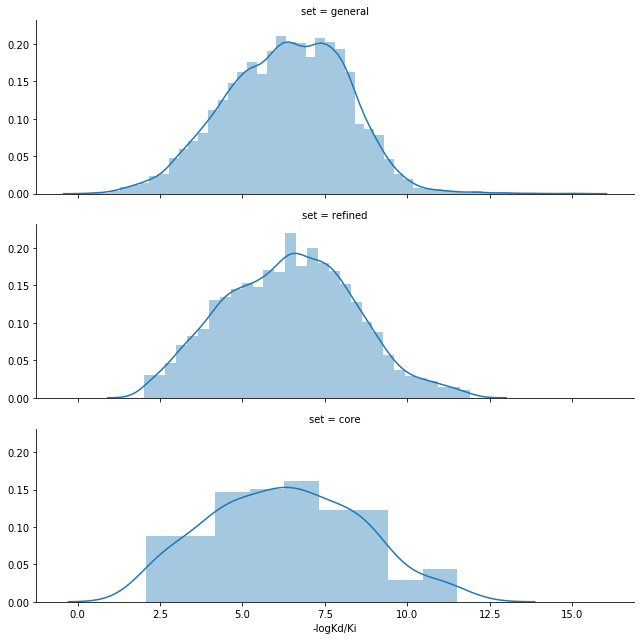

In [12]:
# Check affinity distributions

grid = sns.FacetGrid(affinity_data[affinity_data['include']], row='set', row_order=['general', 'refined', 'core'],
                     size=3, aspect=3)
grid.map(sns.distplot, '-logKd/Ki');

In [13]:
affinity_data[['pdbid']].to_csv('pdb.ids', header=False, index=False)

In [14]:
affinity_data[['pdbid', '-logKd/Ki', 'set']].to_csv('affinity_data_cleaned.csv', index=False)

---

# Parse molecules

In [15]:
#dataset_path = {'general': 'general-set-except-refined', 'refined': 'refined-set', 'core': 'refined-set'}
dataset_path = {'refined': 'test-set'}

In [18]:
%%bash -s $path

# Prepare pockets with UCSF Chimera - pybel sometimes fails to calculate the charges.
# Even if Chimera fails to calculate several charges (mostly for non-standard residues),
# it returns charges for other residues.

path=$1

#for dataset in general-set-except-refined refined-set; do
for dataset in test-set; do
    echo $dataset
    for pdbfile in $path/$dataset/*/*_pocket.pdb; do
        mol2file=${pdbfile%pdb}mol2
        
        if [[ ! -e $mol2file ]]; then
            !chimera
            echo -e "open $pdbfile \n addh \n addcharge \n write format mol2 0 tmp.mol2 \n stop" | chimera --nogui
            # Do not use TIP3P atom types, pybel cannot read them
            sed 's/H\.t3p/H    /' tmp.mol2 | sed 's/O\.t3p/O\.3  /' > $mol2file
        fi
    done 
done > chimera_rw.log

bash: line 15: !chimera: command not found
bash: line 16: chimera: command not found
sed: tmp.mol2: No such file or directory


In [45]:
featurizer = Featurizer()
charge_idx = featurizer.FEATURE_NAMES.index('partialcharge')

with h5py.File('%s/core2013.hdf' % path, 'w') as g:
    j = 0

    for dataset_name, data in affinity_data.groupby('set'):

        print(dataset_name, 'set')
        i = 0
        ds_path = dataset_path[dataset_name]


        with h5py.File('%s/%s.hdf' % (path, dataset_name), 'w') as f:
            for _, row in data.iterrows():

                name = row['pdbid']
                affinity = row['-logKd/Ki']

                ligand = next(pybel.readfile('mol2', '%s/%s/%s/%s_ligand.mol2' % (path, ds_path, name, name)))
                # do not add the hydrogens! they are in the strucutre and it would reset the charges

                try:
                    pocket = next(pybel.readfile('mol2', '%s/%s/%s/%s_pocket.mol2' % (path, ds_path, name, name)))
                    # do not add the hydrogens! they were already added in chimera and it would reset the charges
                except:
                    warnings.warn('no pocket for %s (%s set)' % (name, dataset_name))
                    continue

                ligand_coords, ligand_features = featurizer.get_features(ligand, molcode=1)
                assert (ligand_features[:, charge_idx] != 0).any()
                pocket_coords, pocket_features = featurizer.get_features(pocket, molcode=-1)
                assert (pocket_features[:, charge_idx] != 0).any() 

                centroid = ligand_coords.mean(axis=0)
                ligand_coords -= centroid
                pocket_coords -= centroid

                data = np.concatenate((np.concatenate((ligand_coords, pocket_coords)),
                                       np.concatenate((ligand_features, pocket_features))), axis=1)

                if row['include']:
                    dataset = f.create_dataset(name, data=data, shape=data.shape, dtype='float32', compression='lzf')
                    dataset.attrs['affinity'] = affinity
                    i += 1
                else:
                    dataset = g.create_dataset(name, data=data, shape=data.shape, dtype='float32', compression='lzf')
                    dataset.attrs['affinity'] = affinity
                    j += 1

        print('prepared', i, 'complexes')
    print('excluded', j, 'complexes')

core set


/Users/prguser/opt/anaconda3/envs/pafnucy/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: no pocket for 3ao4 (core set)
/Users/prguser/opt/anaconda3/envs/pafnucy/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: no pocket for 3i3b (core set)
/Users/prguser/opt/anaconda3/envs/pafnucy/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: no pocket for 1uto (core set)
/Users/prguser/opt/anaconda3/envs/pafnucy/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: no pocket for 1ps3 (core set)


OSError: No such file: '../PDBbind/refined-set/1qi0/1qi0_ligand.mol2'

In [17]:
with h5py.File('%s/core.hdf' % path, 'r') as f, \
     h5py.File('%s/core2013.hdf' % path, 'r+') as g:
    for name in f:
        if name in core2013:
            dataset = g.create_dataset(name, data=f[name])
            dataset.attrs['affinity'] = f[name].attrs['affinity']

# Protein data

In [50]:
protein_data = pd.read_csv('../PDBbind/plain-text-index/index/INDEX_general_PL_name.2019',
                           comment='#', sep='  ', engine='python', na_values='------',
                           header=None, names=['pdbid', 'year', 'uniprotid', 'name'])

protein_data.head()

,pdbid,year,uniprotid,name
0,6mu1,2018,P29994,"INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1"
1,3t8s,2011,P29994,"INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1"
2,1n4k,2002,P11881,"INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1"
3,5urm,2017,O75643,U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...
4,5urj,2017,O75643,U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...


In [51]:
# we assume that PDB IDs are unique
assert ~protein_data['pdbid'].duplicated().any()

protein_data = protein_data[np.in1d(protein_data['pdbid'], affinity_data['pdbid'])]

# check for missing values
protein_data.isnull().any()

pdbid        False
year         False
uniprotid     True
name          True
dtype: bool

In [56]:
protein_data[protein_data['uniprotid'].isnull()]

,pdbid,year,uniprotid,name
360,6d50,2018,NaN,"GLYCOSYL HYDROLASES FAMILY 2, SUGAR BINDING DO..."
361,5hv1,2016,NaN,PHOSPHOENOLPYRUVATE SYNTHASE
612,2x24,2011,NaN,ACETYL-COA CARBOXYLASE
673,6mvu,2018,NaN,ALDEHYDE DEHYDROGENASE
748,6f92,2018,NaN,"PUTATIVE ALPHA-1,2-MANNOSIDASE"
...,...,...,...,...
17647,2r5b,2007,NaN,GP41 N-PEPTIDE
17648,2r5d,2007,NaN,GP41 N-PEPTIDE
17659,6fx1,2018,NaN,LECTIN
17663,4u5t,2014,NaN,VBP LEUCINE ZIPPER


In [55]:
# fix rows with wrong separators between protein ID and name

for idx, row in protein_data[protein_data['name'].isnull()].iterrows():
    uniprotid = row['uniprotid'][:6]
    name = row['uniprotid'][7:]
    protein_data.loc[idx, ['uniprotid', 'name']] = [uniprotid, name]

protein_data.isnull().any()

pdbid        False
year         False
uniprotid     True
name         False
dtype: bool

In [22]:
protein_data.to_csv('protein_data.csv', index=False)